In [1]:
!pip install transformers datasets scikit-learn pandas 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
!pip install -U accelerate



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # should be True
print(torch.cuda.get_device_name(0))  # should print your GPU name


2.7.1+cu118
True
NVIDIA GeForce GTX 1650


In [4]:
import pandas as pd
import numpy as np
import torch


In [5]:
data = pd.read_csv('../artifacts/preprocessed_comment_dataset.csv',keep_default_na=False)
data['label'] = data['label'].astype(str)

In [6]:
print(data['label'].unique())

['BaseballBat' 'HitAndRun' 'LipKissing' 'BombExplotionInPublic'
 'KillCowWithKnife' 'None']


In [7]:
data.shape

(14023, 4)

In [8]:
data.head()

,id,comment,label,label_encoded
0,1,මෑන් අයිඩීක් ඔබේ පරිගණක පිරිවිතර මොනවාද ඔබ නැව...,BaseballBat,0
1,2,සහෝදරයා ඔබට වෙව්ට කළේ කුමක්ද,BaseballBat,0
2,3,දුප්පත් විල්ලෙයි,BaseballBat,0
3,4,බ්රෝ කුරිරු යක්ෂයා පත් විය,BaseballBat,0
4,5,සහෝදරයා තම මිතුරා අපයෝජනය කරයි,BaseballBat,0


In [19]:
data.tail()

,id,comment,label,label_encoded
14018,14019,හැරිම ලස්සන දවසක්,None,5
14019,14020,ඔයා හරිම හොදයි,None,5
14020,14021,ළමයා දක්ෂ ළමයෙක්,None,5
14021,14022,මෙතන මාර ලස්සනයි,None,5
14022,14023,ඔයා හොඳට ඉගෙන ගන්න,None,5


####  Label Encoding

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

#### Split Dataset

In [21]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['comment'].tolist(),
    data['label_encoded'].tolist(),
    test_size=0.2,
    stratify=data['label_encoded'],
    random_state=42
)


#### Tokenization

In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


#### Dataset Preparation

In [23]:
class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CommentDataset(train_encodings, train_labels)
val_dataset = CommentDataset(val_encodings, val_labels)


####  Load Pretrained Model

In [24]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(label_encoder.classes_))


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Compute Class Weights (For Imbalance Handling)

In [27]:
class_counts = np.bincount(data['label_encoded'])
class_weights = 1.0 / class_counts
normalized_weights = class_weights / class_weights.sum()
weights_tensor = torch.tensor(normalized_weights, dtype=torch.float)

#### Define Custom Weighted Trainer

In [28]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=weights_tensor.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


#### Define Training Arguments

In [29]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,  # Increase for early stopping to kick in
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    lr_scheduler_type='linear',  # <-- Scheduler
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # stops if no improvement in 2 evals
)


In [30]:
trainer.train() 

Epoch,Training Loss,Validation Loss
1,1.486300,1.428226
2,1.375100,1.299422
3,1.334100,1.239376
4,1.090300,1.259139
5,1.068700,1.249215


TrainOutput(global_step=3510, training_loss=1.2488652583880302, metrics={'train_runtime': 26240.3578, 'train_samples_per_second': 4.275, 'train_steps_per_second': 0.268, 'total_flos': 3689607279006720.0, 'train_loss': 1.2488652583880302, 'epoch': 5.0})

# Evaluate the Model

In [31]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(val_labels, preds, target_names=label_encoder.classes_))


                       precision    recall  f1-score   support

          BaseballBat       0.52      0.65      0.58       502
BombExplotionInPublic       0.72      0.50      0.59       437
            HitAndRun       0.50      0.59      0.54       479
     KillCowWithKnife       0.61      0.59      0.60       449
           LipKissing       0.44      0.52      0.47       398
                 None       0.52      0.40      0.45       540

             accuracy                           0.54      2805
            macro avg       0.55      0.54      0.54      2805
         weighted avg       0.55      0.54      0.54      2805



#### Confusion Matrix with Heatmap

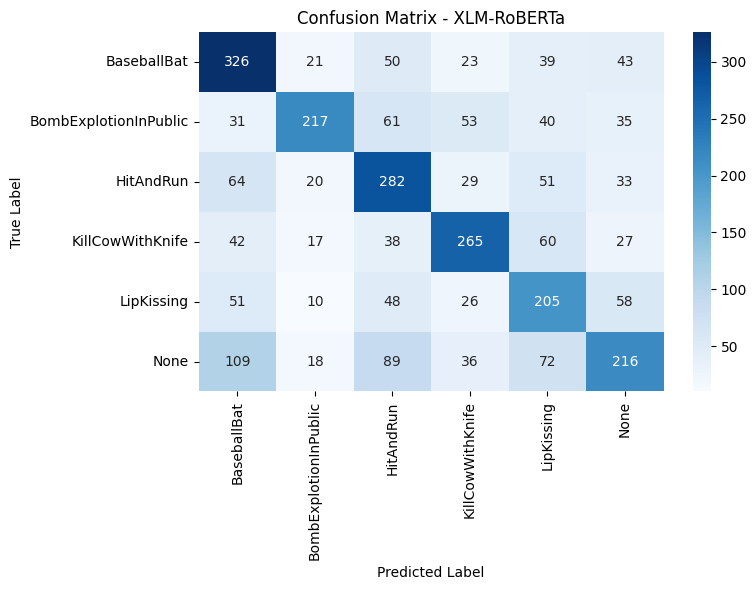

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(val_labels, preds)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XLM-RoBERTa")
plt.tight_layout()
plt.show()


#### Accuracy per Class

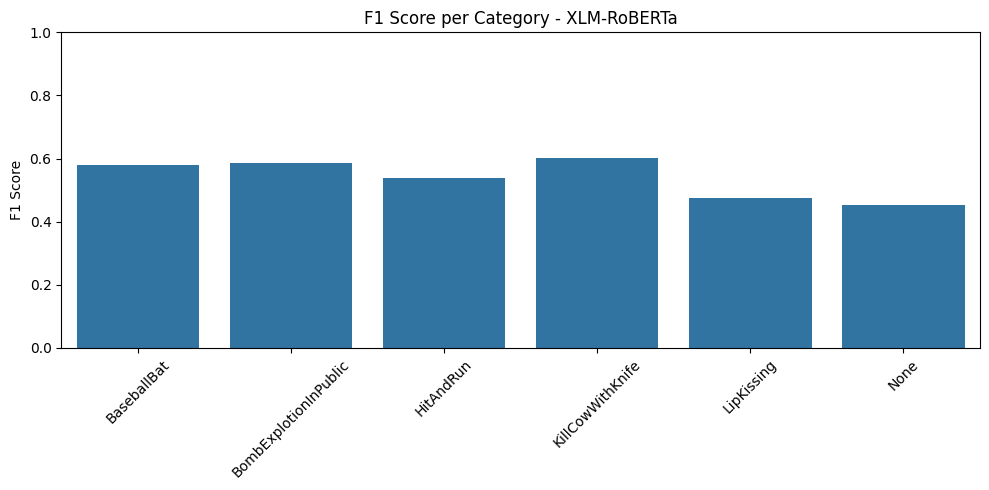

In [40]:
import numpy as np

report = classification_report(val_labels, preds, target_names=label_encoder.classes_, output_dict=True)

class_names = list(report.keys())[:-3]  # remove 'accuracy', 'macro avg', 'weighted avg'
accuracies = [report[label]['f1-score'] for label in class_names]

plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=accuracies)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("F1 Score per Category - XLM-RoBERTa")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


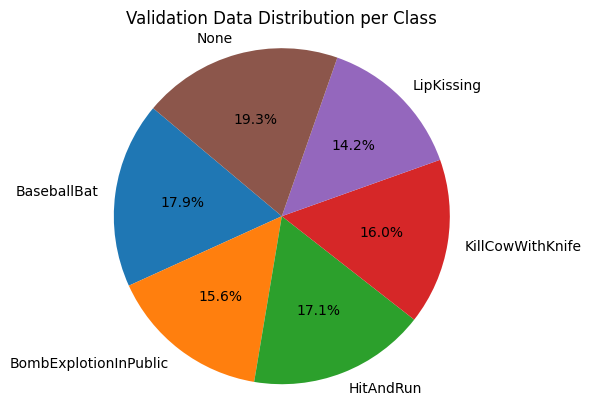

In [41]:
import pandas as pd

val_series = pd.Series(val_labels)
val_class_counts = val_series.value_counts().sort_index()
plt.pie(val_class_counts, labels=label_encoder.classes_, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title("Validation Data Distribution per Class")
plt.show()


#### Save the trained model and tokenizer

In [32]:
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")


('saved_model\\tokenizer_config.json',
 'saved_model\\special_tokens_map.json',
 'saved_model\\tokenizer.json')

In [33]:
import joblib

# Save the LabelEncoder
joblib.dump(label_encoder, "saved_model/label_encoder.joblib")

['saved_model/label_encoder.joblib']

#### Load the model for inference

In [34]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("saved_model")
tokenizer = AutoTokenizer.from_pretrained("saved_model")

model.eval()  # Put model in evaluation mode


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

#### Predict a new comment

In [38]:
def classify_comment(comment, model, tokenizer, label_encoder):
    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
        return label_encoder.inverse_transform([predicted_class_id])[0]

# Example
classify_comment("බෝම්බ ගහලා මිනිස්සු නිකන් සත්තු වගෙ මරලා දානවා.", model, tokenizer, label_encoder)


'BombExplotionInPublic'